In [66]:
import pandas as pd

# Load queries info
RESULTS_DIR = "/home/mpizarro/results/"
queries_dict_fn = "/home/mpizarro/queries_df.csv"
queries_df = pd.read_csv(queries_dict_fn)

# Leer resultados de pattern spotting
def read_results(filename):
    ps_fn = RESULTS_DIR + filename
    ps_dict = {}
    with open(ps_fn, "r") as f:
        ps_results = f.readlines()
    ps_results = [x.strip().split(":") for x in ps_results[38:]]
    for query_id, result in ps_results:
        ps_dict[query_id + ".jpg"] = float(result)
    return ps_dict

In [67]:
ps_dict = read_results("mix_lora_results.txt")
queries_df['ps'] = queries_df.apply(lambda x: ps_dict[x["filename"]], axis=1)
queries_df['ps'].describe()

count    1447.000000
mean        0.630004
std         0.245537
min         0.000000
25%         0.438650
50%         0.677800
75%         0.813600
max         1.000000
Name: ps, dtype: float64

In [68]:
ap_per_class = queries_df.groupby(['class'])['ps'].mean()#.sort_values(ascending=False)
print(ap_per_class)

class
BP                 0.856792
D                  0.450997
S                  0.626482
T                  0.413762
bateau             0.348808
bateau_d           0.231300
bateau_g           0.346225
croix              0.776798
double_sep         0.606032
encadrement        0.596913
grand_A            0.860573
henri_d            0.000000
henri_g            0.000000
losange            0.976335
marqeur            0.735407
obj_1              0.572050
obj_2              0.987850
obj_3              1.000000
obj_31             1.000000
obj_34             0.820937
obj_35             1.000000
obj_36             1.000000
obj_37             1.000000
obj_38             0.028950
obj_39             0.750000
obj_40             0.628986
obj_42             0.525000
obj_61             0.970200
pdp                0.972328
petit_A            0.543683
rubanlettrine      0.248512
rubanlettrine_b    0.119700
simple_sep         0.292552
status             0.622625
triple_sep         0.473793
Name: ps, dtyp

In [69]:
print("mAP:")
print(queries_df.groupby(['size_cat', 'ar_cat'])['ps'].mean())

mAP:
size_cat  ar_cat    
big       non-square    0.623714
          square        0.784089
small     non-square    0.598550
          square        0.806858
Name: ps, dtype: float64


# Plots

In [57]:
import cv2
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image, ImageOps
from torch.utils.data import DataLoader

sys.path.append("/home/mpizarro/DINOv2_LoRA")
from DINOv2_LoRA.src.vision_transformer import vit_base
from DINOv2_LoRA.src.vit_lora import vit_lora
from DINOv2_LoRA.src.dataset_docexplore_eval import DocExploreEval, DocExploreQueries

def show_ranking_comparison(model1, model2, query):
    with open(f"/home/mpizarro/results/{model1}_images.txt", "r") as f:
        lines1 = f.readlines()
    with open(f"/home/mpizarro/results/{model1}_1000.txt", "r") as f:
        retrieval1 = f.readlines()
    with open(f"/home/mpizarro/results/{model1}_scores.txt", "r") as f:
        l_scores1 = f.readlines()
    paths1 = [x for x in lines1 if f"/{query}.jpg" in x][0]
    paths1 = paths1[:-1].split(", ")[1:]
    images1 = [cv2.imread(path) for path in paths1]
    images1 = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images1 if img is not None]
    bboxes1 = [x for x in retrieval1 if x.startswith(f"{query}:")][0]
    bboxes1 = bboxes1.split(":")[-1].split(" ")[:10]
    scores1 = [x for x in l_scores1 if x.startswith(f"{query}:")][0]
    scores1 = scores1.split(":")[-1].split(" ")[:10]
    
    with open(f"/home/mpizarro/results/{model2}_images.txt", "r") as f:
        lines2 = f.readlines()
    with open(f"/home/mpizarro/results/{model2}_1000.txt", "r") as f:
        retrieval2 = f.readlines()
    with open(f"/home/mpizarro/results/{model2}_scores.txt", "r") as f:
        l_scores2 = f.readlines()
    paths2 = [x for x in lines2 if f"/{query}.jpg" in x][0]
    paths2 = paths2[:-1].split(", ")[1:]
    images2 = [cv2.imread(path) for path in paths2]
    images2 = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images2 if img is not None]
    bboxes2 = [x for x in retrieval2 if x.startswith(f"{query}:")][0]
    bboxes2 = bboxes2.split(":")[-1].split(" ")[:10]
    scores2 = [x for x in l_scores2 if x.startswith(f"{query}:")][0]
    scores2 = scores2.split(":")[-1].split(" ")[:10]
    
    fig, axs = plt.subplots(2, 11, figsize=(30, 10))
    
    for i in range(11):
        if i == 0:
            axs[0, i].set_title(model1)
            axs[1, i].set_title(model2)
        else:
            x1, y1, x2, y2 = bboxes1[i-1].split("-")[1:]
            images1[i] = images1[i][int(y1):int(y2), int(x1):int(x2), :] #cv2.rectangle(images1[i], (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)
            
            x1, y1, x2, y2 = bboxes2[i-1].split("-")[1:]
            images2[i] = images2[i][int(y1):int(y2), int(x1):int(x2), :] #cv2.rectangle(images2[i], (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)
            
            axs[0, i].set_title(paths1[i].split("/")[-1] + "\n" + scores1[i-1][:5])
            axs[1, i].set_title(paths2[i].split("/")[-1] + "\n" + scores2[i-1][:5])
            
        axs[0, i].imshow(images1[i])
        axs[0, i].axis("off")
        axs[1, i].imshow(images2[i])
        axs[1, i].axis("off")
    
    plt.show()
    
def show_ranking_per_page(model, query, page, n, thickness):
    data_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_dataset = DocExploreEval(f"/home/mpizarro/data/docexplore_detections/page{page}.pkl", transform=data_transforms)
    image_loader = DataLoader(dataset=image_dataset, batch_size=64, num_workers=12, shuffle=False)
    cataloges_dataset = DocExploreQueries("/home/mpizarro/DINOv2_LoRA/src/docexplore_photos_list.txt", transform=data_transforms)
    query_path = cataloges_dataset.get_query_path(query)
    query_img = Image.open(query_path).convert('RGB')
    query_data = ImageOps.pad(query_img, size=(224, 224))
    query_data = data_transforms(query_data).unsqueeze(0)
    
    if model == "ibot_horae":
        model = vit_base().to(device)
        model_checkpoint = torch.load("/home/mpizarro/out/horae_ibot/backbone.pth", map_location=device, weights_only=False)
    elif model == "ibot_lora":
        model = vit_lora().to(device)
        model_checkpoint = torch.load("/home/mpizarro/out/horae_lora/ibot_lora_horae_teacher.pth", map_location=device, weights_only=False)
    model.load_state_dict(model_checkpoint['state_dict'])   
    
    distance_fn = lambda x, y: F.cosine_similarity(x, y, dim=-1)
    
    distance_values = []
    labels_images = []
    bbox_images = []
    with torch.no_grad():
        query_emb = model(query_data.to(device))
        for (image, labe_bbox, _) in image_loader:
            image_feat = model(image.to(device)) # [batch_size, 512]

            bbox = [l.split("_")[-1].split("-") for l in labe_bbox]
            bbox = [[int(c) for c in b] for b in bbox]
            label = torch.tensor([int(l.split("_")[0]) for l in labe_bbox])
            
            distance = distance_fn(query_emb.unsqueeze(1), image_feat.unsqueeze(0))

            distance_values.append(distance)
            labels_images.append(label.unsqueeze(0))
            bbox_images.append(torch.tensor(bbox).unsqueeze(0))
    
    all_query_distance = torch.cat(distance_values, dim=1).to(device) # [queries, total_images]
    all_bbox_images = torch.cat(bbox_images, dim=1).to(device) # [1, total_images]

    torch.cuda.empty_cache()
    del distance_values, labels_images, bbox_images
    
    max_values, max_indices = torch.topk(all_query_distance, n, dim=1, largest=True, sorted=True) # [n_cataloges, top_k]
    max_bbox = all_bbox_images[0][max_indices]
    max_bbox_row = max_bbox[all_query_distance[0][max_indices] >= 0]

    query_img = np.array(query_img)
    page_img = cv2.cvtColor(cv2.imread(f"/home/data/cstears/DocExplore_images/page{page}.jpg"), cv2.COLOR_BGR2RGB)
    
    bboxes = max_bbox_row.tolist()
    out_boxes = []
    while bboxes:
        actual_box = bboxes.pop(0)
        out_boxes.append(actual_box)
        bboxes = [box for box in bboxes if iou(actual_box, box) < 0.3]
    
    for i, bbox in enumerate(out_boxes):
        x1, y1, x2, y2 = bbox
        cv2.rectangle(page_img, (x1, y1), (x2, y2), (0, 0, 255), thickness)
        #cv2.putText(page_img, f"{max_values[0][i].item():.3f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
    
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1]) 
    ax1.imshow(query_img)
    ax1.set_title(f"query {query}")
    ax1.axis("off")
    ax2.imshow(page_img)
    ax2.set_title(f"page {page}")
    ax2.axis("off")
    plt.show()
    
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

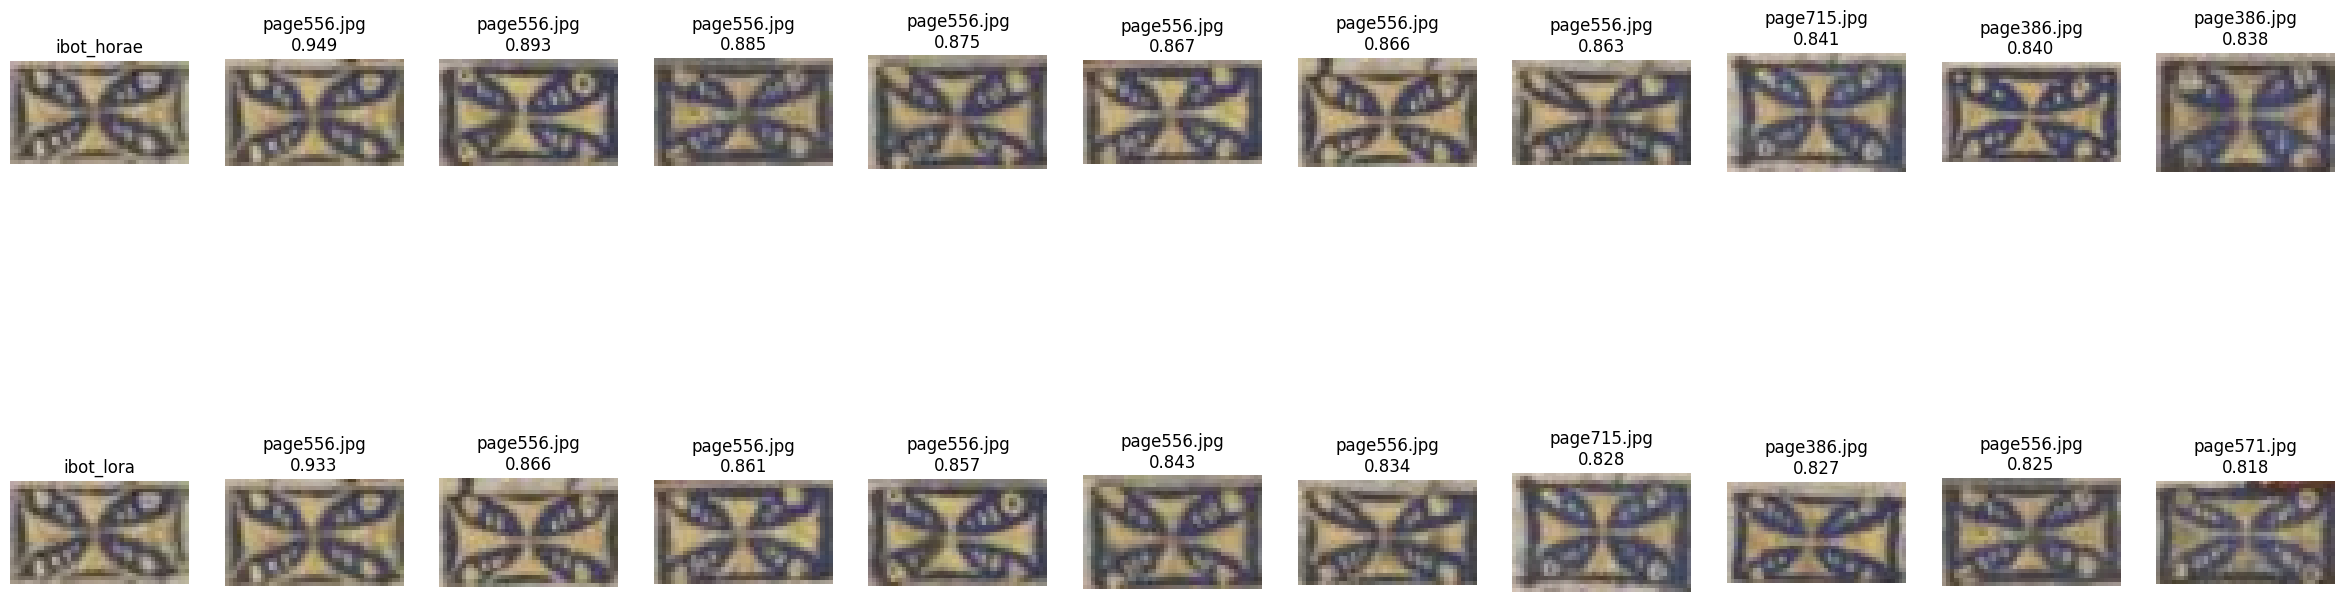

In [34]:
show_ranking_comparison("ibot_horae", "ibot_lora", 233)

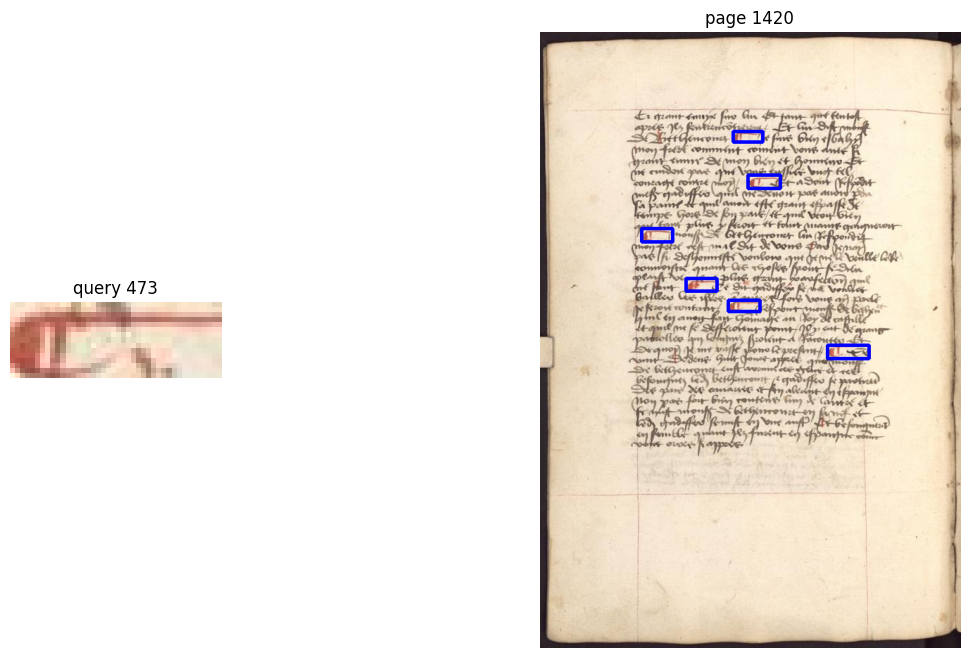

In [65]:
show_ranking_per_page("ibot_lora", query=473, page=1420, n=7, thickness=3)

## Document retrieval

In [23]:
with open("/home/mpizarro/results/ibot_lora_dr.txt", "w") as f:
    with open("/home/mpizarro/results/ibot_lora_1000_dr.txt", "r") as f_orig:
        for line in f_orig:
            vistos = set()
            x_orig = line.strip().split(":")
            x = x_orig[-1].split("\t")
            final_str = ""
            for item in x:
                if item not in vistos:
                    vistos.add(item)
                    final_str += f"{item}\t"
            f.write(f"{x_orig[0]}:{final_str}\r\n")